# End To End Demo

This notebooks demonstrates the data flow of generating a graph from a CSV file using Runway v0.9.0

In [1]:
import os

import pandas as pd
from dotenv import load_dotenv

from neo4j_runway import Discovery, GraphDataModeler, PyIngest, UserInput
from neo4j_runway.code_generation import PyIngestConfigGenerator
from neo4j_runway.llm.openai import OpenAIDataModelingLLM, OpenAIDiscoveryLLM
from neo4j_runway.utils import test_database_connection

load_dotenv()

True

## Load and Describe Data

The USER_GENERATED_INPUT variable contains a general discription and feature descriptions for each feature we'd like to use in our graph.

In [2]:
USER_GENERATED_INPUT = UserInput(general_description='This is data on different cities.',
                                 column_descriptions={
                                     'id': 'unique id for a city.',
                                    'name': 'the city name.',
                                   'state_id': "the id for the state.",
                                   'country_id': 'the id for the country.'
                                    },
    #                             use_cases=[
    #     "Which region contains the most subregions?", 
    #     "What currencies are most popular?", 
    #     "Which countries share timezones?"
    # ]  
                                )

In [3]:
data = pd.read_csv("../../../data/countries/cities.csv")

In [4]:
data.head()

,id,name,state_id,state_code,state_name,country_id,country_code,country_name,latitude,longitude,wikiDataId
0,52,Ashkāsham,3901,BDS,Badakhshan,1,AF,Afghanistan,36.68333,71.53333,Q4805192
1,68,Fayzabad,3901,BDS,Badakhshan,1,AF,Afghanistan,37.11664,70.58002,Q156558
2,78,Jurm,3901,BDS,Badakhshan,1,AF,Afghanistan,36.86477,70.83421,Q10308323
3,84,Khandūd,3901,BDS,Badakhshan,1,AF,Afghanistan,36.95127,72.31800,Q3290334
4,115,Rāghistān,3901,BDS,Badakhshan,1,AF,Afghanistan,37.66079,70.67346,Q2670909


## Initialize LLMs

We now initialize the LLMs to use in data discovery and data model creation.

In [5]:
llm_disc = OpenAIDiscoveryLLM(model_name='gpt-4o-mini-2024-07-18', model_params={"temperature": 0})
llm_dm = OpenAIDataModelingLLM(model_name='gpt-4o-2024-05-13', model_params={"temperature": 0.5})

## Discovery

We now load the above data into a Discovery object.

In [6]:
disc = Discovery(llm=llm_disc, user_input=USER_GENERATED_INPUT, data=data)

In [7]:
disc.run(show_result=True, notebook=True)

### Preliminary Analysis of City Data

1. **Data Overview**:
   - The dataset contains **150,454 entries** with **4 columns**: `id`, `name`, `state_id`, and `country_id`.
   - The data types include **3 integer columns** (`id`, `state_id`, `country_id`) and **1 object column** (`name`).
   - There is a single missing value in the `name` column, indicating that one city name is not recorded.

2. **Feature Analysis**:
   - **id**:
     - Unique identifier for each city.
     - The `id` values range from **1 to 153,528** with a mean of **76,407** and a standard deviation of **44,358**. This suggests a wide distribution of city IDs.
     - The distribution is fairly uniform, with no apparent outliers in the ID values.
   
   - **name**:
     - Represents the name of the city.
     - There are **131,996 unique city names** out of **150,453** entries, indicating that many cities have unique names.
     - The most frequent city name is **"Merkez"**, which appears **51 times**. This could suggest that there are multiple cities with the same name, possibly in different states or countries.
     - The presence of a missing value in this column should be addressed, as it may affect data integrity.
   
   - **state_id**:
     - Represents the identifier for the state.
     - The `state_id` ranges from **1 to 5,116** with a mean of **2,678** and a standard deviation of **1,364**. This indicates a diverse range of states represented in the dataset.
     - The distribution suggests that there are likely many states with a varying number of cities.
   
   - **country_id**:
     - Represents the identifier for the country.
     - The `country_id` ranges from **1 to 247** with a mean of **140.66** and a standard deviation of **70.67**. This indicates that the dataset includes cities from a wide range of countries.
     - The distribution shows that most cities belong to a limited number of countries, with some countries having a significantly higher number of cities represented.

3. **Missing Values**:
   - The dataset has **one missing value** in the `name` column. This should be investigated further to determine if it can be filled or if the entry should be removed.

4. **Important Features**:
   - The most important features for analysis and potential graph modeling include:
     - **id**: Essential for uniquely identifying each city.
     - **name**: Important for understanding city identities and potential relationships.
     - **state_id**: Useful for grouping cities by state and understanding state-level relationships.
     - **country_id**: Critical for analyzing cities at a country level and understanding international relationships.

5. **Potential Use Cases**:
   - The data can be used to analyze city distributions across states and countries, identify cities with similar names, and explore relationships between cities, states, and countries.
   - The unique identifiers (`id`, `state_id`, `country_id`) can facilitate the creation of a graph data model to represent these relationships effectively.

## Data Modeling

We can now use our Discovery object to provide context to the LLM for data model generation. We don't *need* the discovery information for this step to work, but it provides much better models.

In [8]:
gdm = GraphDataModeler(
    llm=llm_dm,
    discovery=disc
)

We now generate our first pass data model.

In [9]:
gdm.create_initial_model(max_retries=5)

Received Valid Initial Nodes.
nodes=[Node(label='City', properties=[Property(name='id', type='int', column_mapping='id', alias=None, is_unique=True, part_of_key=False), Property(name='name', type='str', column_mapping='name', alias=None, is_unique=False, part_of_key=False)], source_name='file'), Node(label='State', properties=[Property(name='stateId', type='int', column_mapping='state_id', alias=None, is_unique=True, part_of_key=False)], source_name='file'), Node(label='Country', properties=[Property(name='countryId', type='int', column_mapping='country_id', alias=None, is_unique=True, part_of_key=False)], source_name='file')]
New Data Model Generation Attempt...


DataModel(nodes=[Node(label='City', properties=[Property(name='id', type='int', column_mapping='id', alias=None, is_unique=True, part_of_key=False), Property(name='name', type='str', column_mapping='name', alias=None, is_unique=False, part_of_key=False)], source_name='file'), Node(label='State', properties=[Property(name='stateId', type='int', column_mapping='state_id', alias=None, is_unique=True, part_of_key=False)], source_name='file'), Node(label='Country', properties=[Property(name='countryId', type='int', column_mapping='country_id', alias=None, is_unique=True, part_of_key=False)], source_name='file')], relationships=[Relationship(type='LOCATED_IN_STATE', properties=[], source='City', target='State', source_name='file'), Relationship(type='LOCATED_IN_COUNTRY', properties=[], source='City', target='Country', source_name='file'), Relationship(type='HAS_STATE', properties=[], source='Country', target='State', source_name='file')], metadata=None)

In [10]:
gdm.current_model

DataModel(nodes=[Node(label='City', properties=[Property(name='id', type='int', column_mapping='id', alias=None, is_unique=True, part_of_key=False), Property(name='name', type='str', column_mapping='name', alias=None, is_unique=False, part_of_key=False)], source_name='file'), Node(label='State', properties=[Property(name='stateId', type='int', column_mapping='state_id', alias=None, is_unique=True, part_of_key=False)], source_name='file'), Node(label='Country', properties=[Property(name='countryId', type='int', column_mapping='country_id', alias=None, is_unique=True, part_of_key=False)], source_name='file')], relationships=[Relationship(type='LOCATED_IN_STATE', properties=[], source='City', target='State', source_name='file'), Relationship(type='LOCATED_IN_COUNTRY', properties=[], source='City', target='Country', source_name='file'), Relationship(type='HAS_STATE', properties=[], source='Country', target='State', source_name='file')], metadata=None)

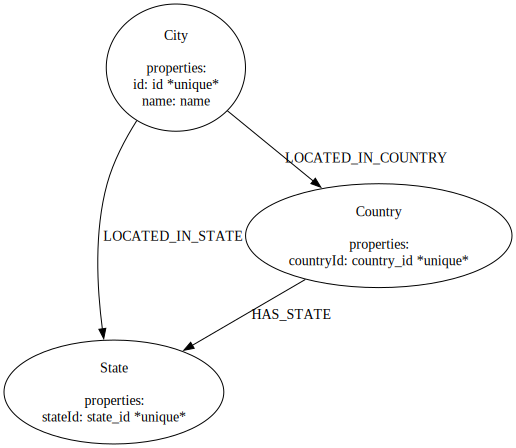

In [11]:
gdm.current_model.visualize()

We can clean this up a bit, so let's prompt the LLM to make some corrections.

In [15]:
gdm.iterate_model(corrections="""Flip the Region and Subregion nodes""")


 Please make corrections to the graph data model using the context provided. Here are the initial discovery findings:
### Preliminary Analysis of Country Data

#### Overall Characteristics:
1. **Data Structure**: The dataset contains 250 entries (countries) and 10 features. The features include both categorical (e.g., name, capital, currency_name) and numerical (e.g., latitude, longitude) data types.
2. **Missing Values**: There are some missing values in the `capital` (5), `region` (2), and `subregion` (3) columns. This indicates that not all countries have a specified capital or belong to a defined region/subregion.
3. **Memory Usage**: The dataset is relatively small, with a memory usage of approximately 19.7 KB.

#### Feature Analysis:
1. **ID**: 
   - Unique identifier for each country.
   - The distribution is uniform, ranging from 1 to 250.

2. **Name**: 
   - Each country has a unique name, with a total of 250 unique entries.
   - This feature is crucial for identifying countr

DataModel(nodes=[Node(label='Country', properties=[Property(name='id', type='int', column_mapping='id', alias=None, is_unique=True, part_of_key=False), Property(name='name', type='str', column_mapping='name', alias=None, is_unique=False, part_of_key=False), Property(name='phoneCode', type='str', column_mapping='phone_code', alias=None, is_unique=False, part_of_key=False), Property(name='capital', type='str', column_mapping='capital', alias=None, is_unique=False, part_of_key=False), Property(name='latitude', type='float', column_mapping='latitude', alias=None, is_unique=False, part_of_key=False), Property(name='longitude', type='float', column_mapping='longitude', alias=None, is_unique=False, part_of_key=False)], source_name='file'), Node(label='Region', properties=[Property(name='region', type='str', column_mapping='region', alias=None, is_unique=True, part_of_key=False)], source_name='file'), Node(label='Subregion', properties=[Property(name='subregion', type='str', column_mapping='su

In [16]:
gdm.current_model

DataModel(nodes=[Node(label='Country', properties=[Property(name='id', type='int', column_mapping='id', alias=None, is_unique=True, part_of_key=False), Property(name='name', type='str', column_mapping='name', alias=None, is_unique=False, part_of_key=False), Property(name='phoneCode', type='str', column_mapping='phone_code', alias=None, is_unique=False, part_of_key=False), Property(name='capital', type='str', column_mapping='capital', alias=None, is_unique=False, part_of_key=False), Property(name='latitude', type='float', column_mapping='latitude', alias=None, is_unique=False, part_of_key=False), Property(name='longitude', type='float', column_mapping='longitude', alias=None, is_unique=False, part_of_key=False)], source_name='file'), Node(label='Region', properties=[Property(name='region', type='str', column_mapping='region', alias=None, is_unique=True, part_of_key=False)], source_name='file'), Node(label='Subregion', properties=[Property(name='subregion', type='str', column_mapping='su

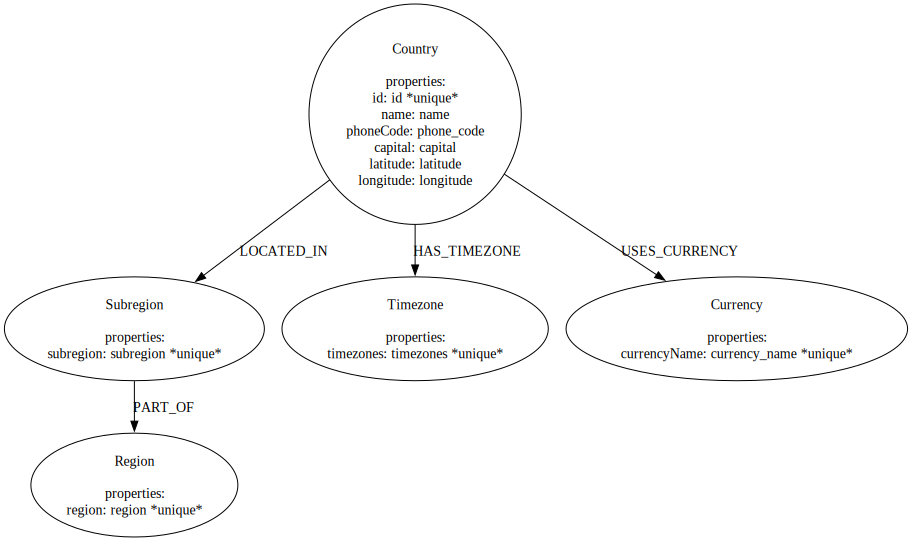

In [17]:
gdm.current_model.visualize()

We can now create some ingestion code to get our data into our database.

## Ingestion Code Generation

We can provide our credentials here in this step if we plan on using PyIngest to load our data. This will inject our credentials into the generated YAML file. If we leave the credential fields blank, then we can just fill in the blanks in the generated YAML file later.

In [18]:
gen = PyIngestConfigGenerator(data_model=gdm.current_model, 
                         username=os.environ.get("NEO4J_USERNAME"), 
                         password=os.environ.get("NEO4J_PASSWORD"), 
                         uri=os.environ.get("NEO4J_URI"), 
                         database=os.environ.get("NEO4J_DATABASE"), 
                         file_directory="data/csv/", source_name="countries.csv")

In [19]:
pyingest_yaml = gen.generate_config_string()
print(pyingest_yaml)

server_uri: bolt://localhost:7687
admin_user: neo4j
admin_pass: password
database: neo4j
basepath: ./

pre_ingest:
  - CREATE CONSTRAINT country_id IF NOT EXISTS FOR (n:Country) REQUIRE n.id IS UNIQUE;
  - CREATE CONSTRAINT region_region IF NOT EXISTS FOR (n:Region) REQUIRE n.region IS UNIQUE;
  - CREATE CONSTRAINT subregion_subregion IF NOT EXISTS FOR (n:Subregion) REQUIRE n.subregion IS UNIQUE;
  - CREATE CONSTRAINT timezone_timezones IF NOT EXISTS FOR (n:Timezone) REQUIRE n.timezones IS UNIQUE;
  - CREATE CONSTRAINT currency_currencyname IF NOT EXISTS FOR (n:Currency) REQUIRE n.currencyName IS UNIQUE;
files:
- chunk_size: 100
  cql: |-
    WITH $dict.rows AS rows
    UNWIND rows AS row
    MERGE (n:Country {id: toIntegerOrNull(row.id)})
    SET n.name = row.name, n.phoneCode = row.phone_code, n.capital = row.capital, n.latitude = toFloatOrNull(row.latitude), n.longitude = toFloatOrNull(row.longitude)
  url: $BASE/data/csv/countries.csv
- chunk_size: 100
  cql: |
    WITH $dict.rows 

## Ingest Data

We can use the generated yaml string above to orchestrate the data loading via a modified PyIngest function. First let's confirm our connection though.

In [20]:
test_database_connection(credentials={"username": os.environ.get("NEO4J_USERNAME"), "password": os.environ.get("NEO4J_PASSWORD"), "uri": os.environ.get("NEO4J_URI")})

{'valid': True, 'message': 'Connection and Auth Verified!'}

In [21]:
PyIngest(config=pyingest_yaml, dataframe=data)

File {} .//data/csv/countries.csv
loading... 0 2024-08-28 09:10:40.049717
loading... 1 2024-08-28 09:10:40.186946
{} : Completed file 2024-08-28 09:10:40.220505
File {} .//data/csv/countries.csv
loading... 0 2024-08-28 09:10:40.221087
loading... 1 2024-08-28 09:10:40.263834
{} : Completed file 2024-08-28 09:10:40.275475
File {} .//data/csv/countries.csv
loading... 0 2024-08-28 09:10:40.275817
loading... 1 2024-08-28 09:10:40.307399
{} : Completed file 2024-08-28 09:10:40.322197
File {} .//data/csv/countries.csv
loading... 0 2024-08-28 09:10:40.322525
loading... 1 2024-08-28 09:10:40.367488
{} : Completed file 2024-08-28 09:10:40.404210
File {} .//data/csv/countries.csv
loading... 0 2024-08-28 09:10:40.404591
loading... 1 2024-08-28 09:10:40.438580
{} : Completed file 2024-08-28 09:10:40.459188
File {} .//data/csv/countries.csv
loading... 0 2024-08-28 09:10:40.459669
loading... 1 2024-08-28 09:10:40.504272
{} : Completed file 2024-08-28 09:10:40.524525
File {} .//data/csv/countries.csv


If we check our database we can see that we've ingested our CSV according to the data model we've created!

![countries-graph-0.9.0.png](../../images/countries-graph-0.9.0.png)